In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [3]:
import pickle
import json
with open("../data/affix_dataset.json", "r", encoding="UTF-8") as fin:
    poly_affixoids = json.load(fin)
with open("../data/affix_dists.pkl", "rb") as fin:
    char_dists = pickle.load(fin)

In [4]:
from sklearn.metrics import silhouette_score
import numpy as np

def compute_silhouette_score(char_item, field_name, seed=12345):
    ex_labels = np.array(char_item["ex_labels"])
    # ex_labels = char_item["ex_labels"]
    dist_mat = char_item[field_name]
    nan_mask = ~np.isnan(dist_mat).all(axis=0)
    dist_mat = dist_mat[nan_mask, :][:, nan_mask]
    ex_labels = ex_labels[nan_mask]
        
    real_score = silhouette_score(
                  dist_mat, ex_labels, 
                  metric="precomputed")
  
    rng = np.random.RandomState(seed)
    # rng = random.Random(seed)
    rand_scores = []  
    for _ in range(1000):  
        # rand_labels = np.array(rng.sample(ex_labels.tolist(), len(ex_labels)))
        # rand_labels = rng.sample(ex_labels, len(ex_labels))            
        rand_labels = rng.choice(ex_labels, len(ex_labels), replace=False)        
        rand_score = silhouette_score(
                      dist_mat, rand_labels, 
                      metric="precomputed")
        rand_scores.append(rand_score)
        
    return real_score, rand_scores

In [6]:
char_item = char_dists["人"]
list(char_item.keys())

['ex_labels',
 'J_target_dists',
 'J_counter_dists',
 'J_cross_dists',
 'pred_emb_dists',
 'tenc_emb_dists',
 'counter_emb_dists',
 'counter_bert_dists']

In [9]:
char_item["J_cross_dists"]

array([[607.02081299, 650.17626953, 978.78881836, 666.6282959 ,
        652.01226807, 608.95336914, 591.64331055, 680.15405273],
       [613.56091309, 600.14794922, 971.28649902, 628.5279541 ,
        635.79168701, 607.29119873, 587.50878906, 657.65618896],
       [726.10687256, 749.25939941, 980.83178711, 770.85302734,
        763.918396  , 738.33947754, 721.23535156, 791.03594971],
       [543.90063477, 562.58905029, 927.55090332, 574.92871094,
        584.23052979, 559.46014404, 539.73803711, 612.20782471],
       [614.63861084, 633.56439209, 978.61419678, 663.01977539,
        615.96697998, 616.82110596, 599.71203613, 676.1697998 ],
       [417.23825073, 464.89590454, 867.5411377 , 505.29855347,
        476.04244995, 419.3578186 , 409.11895752, 518.37689209],
       [420.0305481 , 466.24133301, 865.93365479, 505.34420776,
        479.28713989, 434.19714355, 402.55130005, 514.99975586],
       [475.25012207, 501.65762329, 892.87280273, 537.62756348,
        521.95922852, 479.9710388

In [11]:
char_item = char_dists["人"]

fields = list(char_item.keys())
fields.remove("ex_labels")
fields.remove("J_cross_dists")
for field_name in fields:  
    real_score, rand_scores = compute_silhouette_score(char_item, field_name, 12)
    print(f"-- {field_name} --")
    print("Sample score: ", real_score)
    print("Random p(x>Z): ", 1-np.sum(real_score>rand_scores)/len(rand_scores))


-- J_target_dists --
Sample score:  0.03247304537697411
Random p(x>Z):  0.007000000000000006
-- J_counter_dists --
Sample score:  0.04156077390912944
Random p(x>Z):  0.007000000000000006
-- pred_emb_dists --
Sample score:  -0.017208360523811576
Random p(x>Z):  0.573
-- tenc_emb_dists --
Sample score:  0.022048239892271147
Random p(x>Z):  0.269
-- counter_emb_dists --
Sample score:  -0.007070001825516051
Random p(x>Z):  0.503
-- counter_bert_dists --
Sample score:  0.03032555425735877
Random p(x>Z):  0.118


In [12]:
from tqdm.auto import tqdm

fields = list(char_item.keys())
fields.remove("ex_labels")
fields.remove("J_cross_dists")
var_names = "Jtgt,Jctr,pred,tenc,tencCtr,bertCtr".split(",")
print(list(zip(fields, var_names)))

char_stats = {}
for char, char_item in tqdm(char_dists.items()):
    stat_item = {}    
    for field_name, var_name in zip(fields, var_names):  
        try:
            real_score, rand_scores = compute_silhouette_score(char_item, field_name, 12)
            pval = 1-np.sum(real_score>rand_scores)/len(rand_scores)
        except ValueError:
            real_score, rand_scores = np.NaN, []
            pval = np.NaN
        stat_item[f"{var_name}_sample"] = real_score
        stat_item[f"{var_name}_pval"] = pval
        stat_item[f"{var_name}_rand_scores"] = rand_scores
    char_stats[char] = stat_item


[('J_target_dists', 'Jtgt'), ('J_counter_dists', 'Jctr'), ('pred_emb_dists', 'pred'), ('tenc_emb_dists', 'tenc'), ('counter_emb_dists', 'tencCtr'), ('counter_bert_dists', 'bertCtr')]


  0%|          | 0/796 [00:00<?, ?it/s]

In [13]:
import pandas as pd
char_frame_data = []
for char, stat_item in char_stats.items():
    char_frame_data.append(dict(
        char=char,
        Jtgt_pval=stat_item["Jtgt_pval"],
        Jctr_pval=stat_item["Jctr_pval"],
        pred_pval=stat_item["pred_pval"],
        tenc_pval=stat_item["tenc_pval"],
        tencCtr_pval=stat_item["tencCtr_pval"],
        bertCtr_pval=stat_item["bertCtr_pval"],
    ))
char_frame = pd.DataFrame.from_records(char_frame_data).set_index("char")

In [14]:
import pandas as pd
char_sample_data = []
for char, stat_item in char_stats.items():
    char_sample_data.append(dict(
        char=char,
        Jtgt_sample=stat_item["Jtgt_sample"],
        Jctr_sample=stat_item["Jctr_sample"],
        pred_sample=stat_item["pred_sample"],
        tenc_sample=stat_item["tenc_sample"],
        tencCtr_sample=stat_item["tencCtr_sample"],
        bertCtr_sample=stat_item["bertCtr_sample"],
    ))
char_sample = pd.DataFrame.from_records(char_sample_data).set_index("char")

In [15]:
with open("../data/affix_stats.pkl", "wb") as fout:
    pickle.dump(char_stats, fout)

In [62]:
char_frame.median()

Jtgt_pval       0.0460
Jctr_pval       0.0550
pred_pval       0.1545
tenc_pval       0.2270
tencCtr_pval    0.3590
bertCtr_pval    0.2020
dtype: float64

In [64]:
(char_frame<0.05).sum()/char_frame.shape[0]

Jtgt_pval       0.508794
Jctr_pval       0.483668
pred_pval       0.271357
tenc_pval       0.202261
tencCtr_pval    0.090452
bertCtr_pval    0.204774
dtype: float64

In [17]:
char_frame.iloc[char_frame.Jtgt_pval.argmin()]

Jtgt_pval       0.000
Jctr_pval       0.000
pred_pval       0.011
tenc_pval       0.030
tencCtr_pval    0.155
bertCtr_pval    0.006
Name: 土, dtype: float64

In [61]:
## Trying to show that the similar pattern between target and counter pval is not due 
## to similarities between the Jacobians of target and counter constituents.
self_cross_dists = []
within_target_dists = []
within_counter_dists = []
for itemx in char_dists.values():
    exlabel = np.array(itemx["ex_labels"])
    distx = itemx["J_cross_dists"].diagonal().mean()    
    self_cross_dists.append(distx)
    
    ui = np.triu_indices(len(exlabel),k=1)
    Mt = itemx["J_target_dists"][ui]
    Mc = itemx["J_counter_dists"][ui]
    within_target_dists.append(Mt.mean())
    within_counter_dists.append(Mc.mean())

dist_desc_stat = pd.DataFrame(dict(
        self_corss=pd.Series(self_cross_dists).describe(),
        within_tgt=pd.Series(within_target_dists).describe(),
        within_ctr=pd.Series(within_counter_dists).describe()
    ))
dist_desc_stat

,self_corss,within_tgt,within_ctr
count,796.000000,796.000000,796.000000
mean,601.383322,604.161797,601.564608
std,139.287346,171.558294,135.876161
min,369.008032,312.029851,221.417781
25%,526.236348,514.465238,511.397782
50%,586.620770,584.028259,590.166179
75%,652.260302,661.122911,673.383026
max,2526.616313,3018.340535,1708.744674


In [18]:
poly_affixoids["土"]

[{'def': 'soil,earth,clay,land',
  'ex': [['土石', 50], ['土改', 28], ['土層', 16], ['土堤', 9], ['土壩', 6]]},
 {'def': 'local,native',
  'ex': [['土雞', 22], ['土狗', 17], ['土狼', 5], ['土豪', 5], ['土番', 2]]},
 {'def': 'soil,earth,clay,land',
  'ex': [['水土', 97], ['廢土', 55], ['黃土', 28], ['失土', 10], ['棄土', 8]]}]

In [21]:
char_long = pd.melt(char_frame, var_name="variable", value_name="pval")

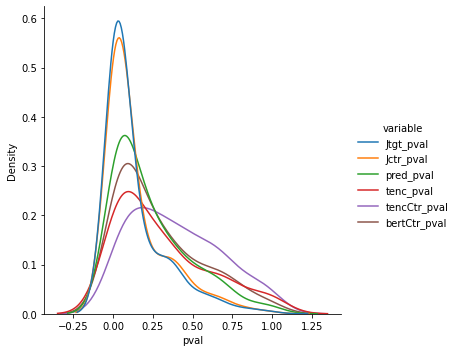

In [77]:
import seaborn as sns
sns.displot(char_long, x="pval", hue="variable", kind="kde", bw_adjust=1.5)

In [23]:
char_sample.median()

Jtgt_sample       0.045496
Jctr_sample       0.040667
pred_sample       0.095463
tenc_sample       0.078031
tencCtr_sample    0.001841
bertCtr_sample    0.019104
dtype: float64

In [24]:
char_sample.corr()

,Jtgt_sample,Jctr_sample,pred_sample,tenc_sample,tencCtr_sample,bertCtr_sample
Jtgt_sample,1.000000,0.800814,0.487929,0.284361,0.357457,0.411212
Jctr_sample,0.800814,1.000000,0.381327,0.211728,0.309814,0.366327
pred_sample,0.487929,0.381327,1.000000,0.505598,0.562318,0.489806
tenc_sample,0.284361,0.211728,0.505598,1.000000,0.271850,0.307653
tencCtr_sample,0.357457,0.309814,0.562318,0.271850,1.000000,0.691416
bertCtr_sample,0.411212,0.366327,0.489806,0.307653,0.691416,1.000000


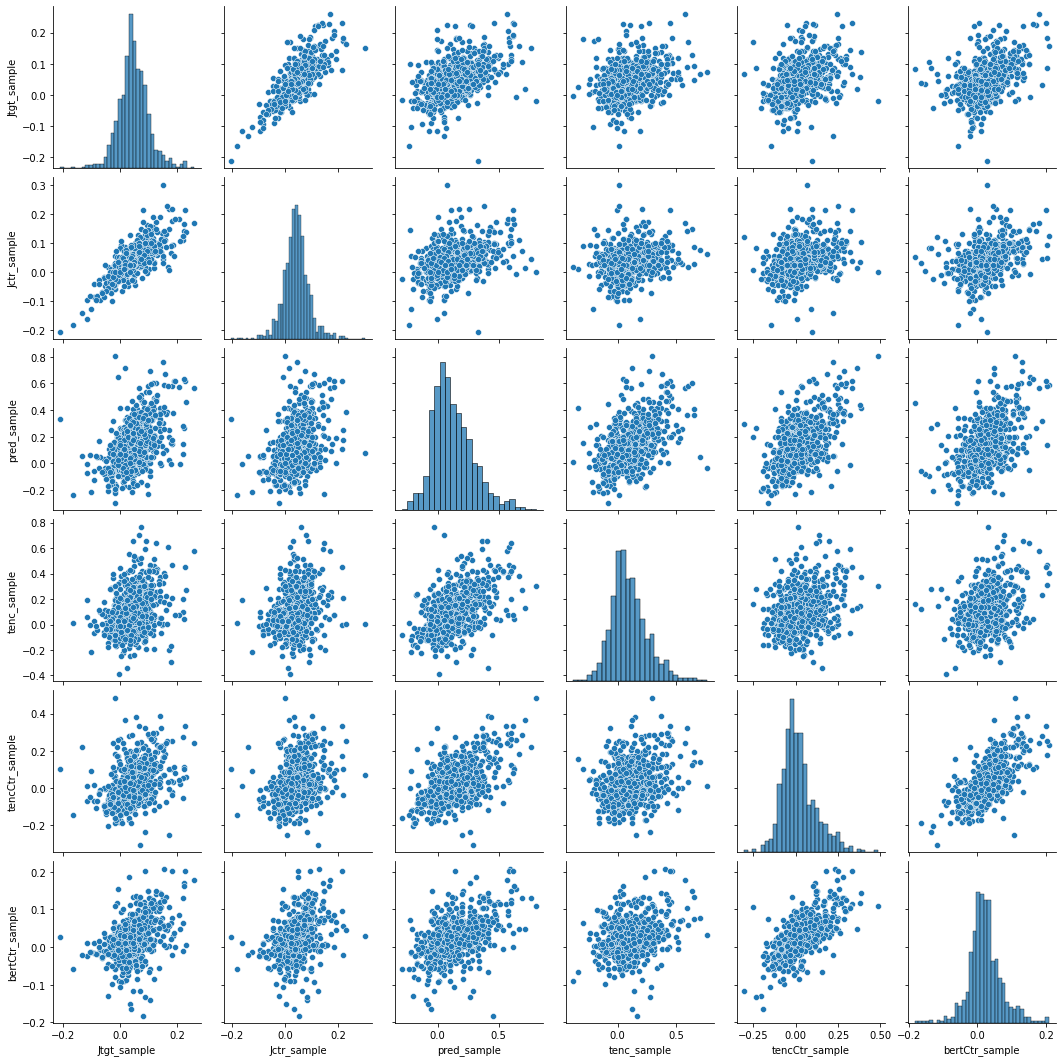

In [25]:
sns.pairplot(char_sample)

In [79]:
char_frame.query("Jtgt_pval<0.001")

,Jtgt_pval,Jctr_pval,pred_pval,tenc_pval,tencCtr_pval,bertCtr_pval
char,,,,,,
土,0.0,0.000,0.011,0.030,0.155,0.006
中,0.0,0.093,0.020,0.018,0.162,0.066
化,0.0,0.610,0.457,0.565,0.635,0.260
方,0.0,0.000,0.000,0.000,0.256,0.005
片,0.0,0.000,0.006,0.045,0.027,0.031
王,0.0,0.000,0.027,0.004,0.024,0.001
台,0.0,0.000,0.009,0.008,0.031,0.034
身,0.0,0.004,0.003,0.002,0.153,0.026
果,0.0,0.000,0.003,0.002,0.031,0.003


In [27]:
char_frame.query("Jtgt_pval>0.5")

,Jtgt_pval,Jctr_pval,pred_pval,tenc_pval,tencCtr_pval,bertCtr_pval
char,,,,,,
上,0.645,0.851,0.000,0.042,0.147,0.009
介,0.526,0.507,0.626,0.232,0.609,0.521
天,0.549,0.544,0.949,0.936,0.743,0.753
引,0.669,0.669,0.669,0.359,0.359,0.359
世,0.630,0.524,0.313,0.633,0.313,0.109
包,0.794,0.526,0.322,0.144,0.117,0.349
卡,0.680,0.680,0.862,0.577,0.715,0.862
母,0.529,0.002,0.364,0.354,0.474,0.044
年,0.923,0.934,0.376,0.070,0.411,0.521
